# Profiling Compton Scattering Processes

Profile $e^- + n \gamma \to e^- + \gamma$ processes with and without spin/pol combinations.

Make sure that the latest dev versions of QEDprocesses and QEDcore are installed (see `./add_QED_dev.jl`). This is intended for Julia version 1.10, other versions may or may not work.

Depending on your hardware, you might have to adjust the `N` constants in each cell. In this case, also adjust the range of the plotted data for it to succeed. Unchanged, it needed about 7GB of RAM and ~1h on my machine (mostly for the fourth cell).

In [1]:
using QEDFeynmanDiagrams
using ComputableDAGs
using RuntimeGeneratedFunctions
RuntimeGeneratedFunctions.init(@__MODULE__)
using QEDprocesses
using QEDcore
using DataFrames
using BenchmarkTools

In [12]:
N = 7
compton_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (SpinUp(), ntuple(_ -> PolX(), n)...),         # incoming particle spin/pols
        (SpinUp(), PolX()),                            # outgoing particle spin/pols
    )

    graph_gen_bench = @benchmark generate_DAG($proc_nocombs)
    
    g_nocombs = generate_DAG(proc_nocombs)

    push!(compton_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

N_no_exec = N
compton_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,1.48452e5,14311.2
2,6,85,386285.0,1.05043e6
3,24,184,1.2388e6,1.82681e6
4,120,395,5.52288e6,4.21641e6
5,720,846,3.44328e7,1.09682e7
6,5040,1809,2.35158e8,2.89058e7
7,40320,3860,1.90453e9,8.97453e7


In [13]:
N = 7
compton_all_sp_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_allcombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (AllSpin(), ntuple(_ -> AllPol(), n)...),      # incoming particle spin/pols
        (AllSpin(), AllPol()),                         # outgoing particle spin/pols
    )

    graph_gen_bench = @benchmark generate_DAG($proc_allcombs)
    
    g_allcombs = generate_DAG(proc_allcombs)

    push!(compton_all_sp_df, (length(feynman_diagrams(proc_allcombs)) * multiplicity(proc_allcombs), length(g_allcombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

N_no_exec = min(N_no_exec, N)
compton_all_sp_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,32,176,1.52861e6,1.8241e6
2,192,642,5.41176e6,3.87775e6
3,1536,2320,2.08763e7,7.89484e6
4,15360,9590,9.60018e7,6.8495e6
5,184320,36876,4.43767e8,1.55056e7
6,2580480,159042,2.34946e9,1.20399e7
7,41287680,625080,1.15393e10,NaN


In [4]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 5
compton_exec_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (SpinUp(), ntuple(_ -> PolX(), n)...),         # incoming particle spin/pols
        (SpinUp(), PolX()),                            # outgoing particle spin/pols
    )

    g_nocombs = generate_DAG(proc_nocombs)

    func = get_compute_function(g_nocombs, proc_nocombs, cpu_st(), @__MODULE__)
    
    psp = gen_process_input(RNG, proc_nocombs)
    
    exec_bench = @benchmark $func($psp)

    push!(compton_exec_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

N_exec = N
compton_exec_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,205.3,1715.47
2,6,85,821.718,4852.14
3,24,184,1713.3,189.365
4,120,395,5291.71,838.278
5,720,846,10360.0,1818.29


In [5]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 5
compton_exec_all_combs_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_allcombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (AllSpin(), ntuple(_ -> AllPol(), n)...),         # incoming particle spin/pols
        (AllSpin(), AllPol()),                            # outgoing particle spin/pols
    )

    g_allcombs = generate_DAG(proc_allcombs)

    func = get_compute_function(g_allcombs, proc_allcombs, cpu_st(), @__MODULE__)

    psp = gen_process_input(RNG, proc_allcombs)

    exec_bench = @benchmark $func($psp)

    push!(compton_exec_all_combs_df, (length(feynman_diagrams(proc_allcombs)), length(g_allcombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

N_exec = min(N_exec, N)
compton_exec_all_combs_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,176,1400.75,150.563
2,6,642,8085.33,803.349
3,24,2320,28525.0,2473.11
4,120,9590,179712.0,14896.8
5,720,36876,621330.0,60598.3


# Plotting

In [6]:
# Colors and Setup
using Plots
using StatsPlots
using Colors
using CurveFit

color1 = parse(RGBA, "#FF1F5B")
color2 = parse(RGBA, "#009ADE")
color3 = parse(RGBA, "#AF58BA")
color4 = parse(RGBA, "#F28522")

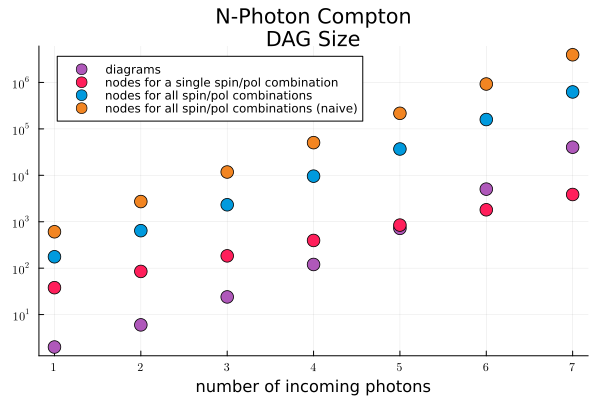

In [18]:
fig = scatter(
    [compton_df.diagrams[1:N_no_exec] compton_df.nodes[1:N_no_exec] compton_all_sp_df.nodes[1:N_no_exec] (compton_df.nodes[1:N_no_exec] .* (2 .^ (4:(3+N_no_exec))))],
    yscale=:log10,
    seriescolor=[color3 color1 color2 color4],
    label=["diagrams" "nodes for a single spin/pol combination" "nodes for all spin/pol combinations" "nodes for all spin/pol combinations (naive)"],
    title="N-Photon Compton\nDAG Size",
    #ylabel="#",
    xlabel="number of incoming photons",
    markersize=7,
    legend_position=:topleft,
    #size=(600, 500),
    xticks=([1:N_no_exec...,], ["\$$i\$" for i in 1:N_no_exec]),
    yticks=([(10^i for i in 1:6)...,], ["\$10^$i\$" for i in 1:6])
)
savefig(fig, "compton_dag_sizes.pdf")
fig

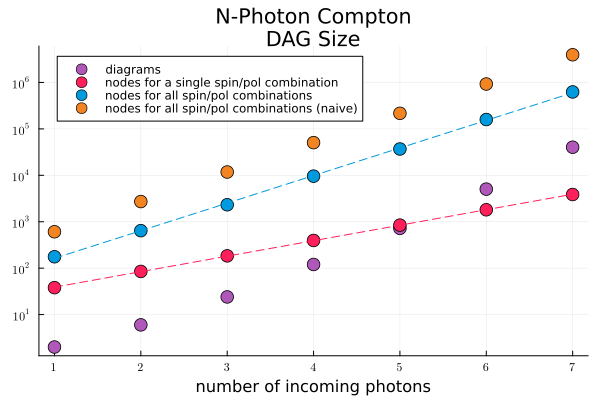

In [19]:
f_nodes_single = curve_fit(ExpFit, Float64.(2:(N_no_exec+1)), Float64.(compton_df.nodes[1:N_no_exec]))
f_nodes_all = curve_fit(ExpFit, Float64.(2:(N_no_exec+1)), Float64.(compton_all_sp_df.nodes[1:N_no_exec]))

plot!(fig, 1:0.05:N_no_exec, f_nodes_single.(2:0.05:(N_no_exec+1)), seriescolor=color1, label = "", linestyle=:dash)
plot!(fig, 1:0.05:N_no_exec, f_nodes_all.(2:0.05:(N_no_exec+1)), seriescolor=color2, label = "", linestyle=:dash)
savefig(fig, "compton_dag_sizes_expfit.pdf")
fig

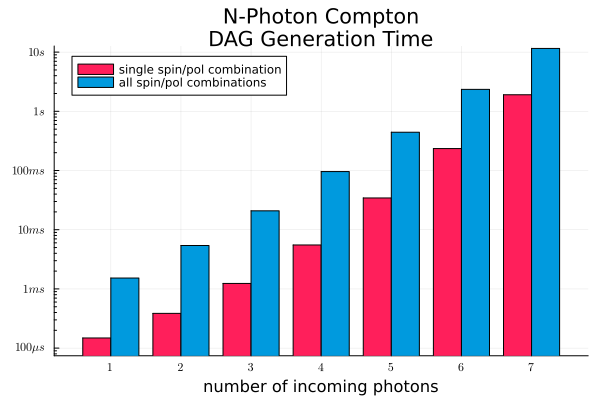

In [16]:
fig = groupedbar(
    ["\$$i\$" for i in 1:N_no_exec],
    [(compton_df.t_med[1:N_no_exec] ./ 1e9) (compton_all_sp_df.t_med[1:N_no_exec] ./ 1e9)],
    #yerr = [(compton_df.t_std ./ 1e9) (compton_all_sp_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title = "N-Photon Compton\nDAG Generation Time",
    label = ["single spin/pol combination" "all spin/pol combinations"],
    xlabel = "number of incoming photons",
    yticks = ([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
        ["\$100μs\$", "\$1ms\$", "\$10ms\$", "\$100ms\$", "\$1s\$", "\$10s\$"]),
    yminorticks = true,
    yaxis=:log10,
    ylim=[0.5*min(compton_df.t_med[1:N_no_exec]...)/1e9, 1.1*max(compton_all_sp_df.t_med[1:N_no_exec]...)/1e9],
)
savefig(fig, "compton_dag_gen_time.pdf")
fig

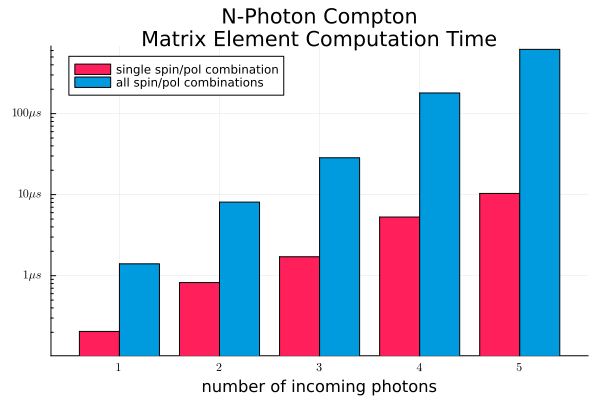

In [17]:
fig = groupedbar(
    ["\$$i\$" for i in 1:N_exec],
    [(compton_exec_df.t_med[1:N_exec] ./ 1e9) (compton_exec_all_combs_df.t_med[1:N_exec] ./ 1e9)],
    #yerr = [(compton_exec_df.t_std ./ 1e9) (compton_exec_all_combs_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title="N-Photon Compton\nMatrix Element Computation Time",
    label=["single spin/pol combination" "all spin/pol combinations"],
    xlabel="number of incoming photons",
    yticks=([1e-6, 1e-5, 1e-4],
        ["\$1μs\$", "\$10μs\$", "\$100μs\$"]),
    yminorticks=true,
    yaxis=:log10,
    ylim=[0.5 * min(compton_exec_df.t_med[1:N_exec]...) / 1e9, 1.1 * max(compton_exec_all_combs_df.t_med[1:N_exec]...) / 1e9],
)
savefig(fig, "compton_exec_time.pdf")
fig

[176, 642, 2320, 9590, 36876]


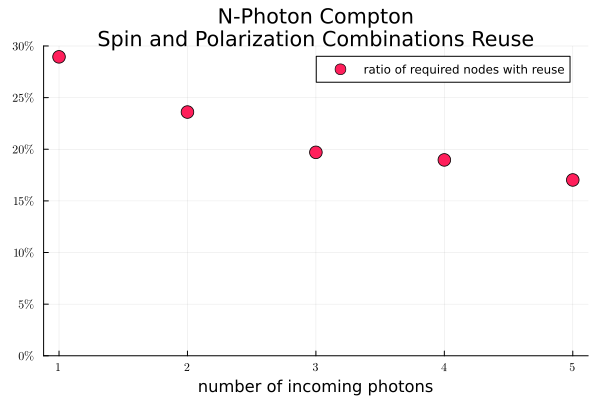

In [11]:
x = 1:5 # number of incoming photons
sp_combinations_total = compton_df.nodes[1:5] .* (2 .^(x.+3)) # nodes in naive approach (single combination * number of combinations)
combination_dag_scaling = compton_all_sp_df.nodes[1:5]

fig = scatter(
    x,
    100. .* combination_dag_scaling ./ sp_combinations_total,
    #yscale=:identity,
    ylim = (0, 30),
    seriescolor=color1,
    label="ratio of required nodes with reuse",
    title="N-Photon Compton\nSpin and Polarization Combinations Reuse",
    ylabel="",
    xlabel="number of incoming photons",
    markersize=7,
    legend_position=:topright,
    #size=(600, 500),
    xticks=([1, 2, 3, 4, 5, 6, 7], ["\$1\$", "\$2\$", "\$3\$", "\$4\$", "\$5\$", "\$6\$", "\$7\$"]),
    yticks=([0, 5, 10, 15, 20, 25, 30], ["\$0\\%\$", "\$5\\%\$", "\$10\\%\$", "\$15\\%\$", "\$20\\%\$", "\$25\\%\$", "\$30\\%\$"]),
    #yminorticks=true,
)
savefig(fig, "compton_combinations_scaling.pdf")
println(combination_dag_scaling)
fig